# **Apple Identification Model** 

See the [README.md](README.md) for a full project overview, setup instructions, and additional context.

## **Imports**

In [1]:
# Database API
from kaggle.api.kaggle_api_extended import KaggleApi

# File and directory management
import os
import json
import shutil
from typing import TypedDict
from pathlib import Path

# Data manipulation
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Machine learning
import tensorflow as tf

# Keras for deep learning

from keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import img_to_array, load_img
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


## **Table of Contents**

[**Dataset**](#dataset) — Overview of the dataset and filtering process

- [**Filtering Data**](#filtering-data) — Selecting only apple images from the full dataset  
- [**Data Preprocessing**](#data-preprocessing) — Cleaning and organizing the apple dataset for training  
- [**Dataset Structure**](#dataset-structure) — Explaining the layout of the training, test, and validation sets  
- [**Examples of Each Species**](#examples-of-each-species) — Visualizing the apple species in the dataset  
  
[**Models**](#models) — CNN architecture for apple species classification

- [**CNN**](#convolutional-neural-network) — Structure and layers of the neural network  
- [**Ensamble**](#ensamble) — Optimizer, loss function, and training parameters  
    - [**Initilization**](#initilization-for-ensamble) - Holds varriables and helper functions
    - [**MobileNetV2**](#mobilenetv2) - Trained on input size of (100, 100, 3)
    - [**ResNet50**](#resnet50) - Trained on input size of (224, 224, 3)
    - [**EfficientNetB0**](#efficientnetb0) - Trained on input size (224, 224, 3)
- [**Evaluation**](#evaluation) — Accuracy, loss, and model performance analysis

[**Application**](#application) - Model in action to detect different species of apples

[**Results**](#results) — Final performance metrics and visualizations

[**Conclusion**](#conclusion) — Summary of results and future work

## **Dataset**

The dataset used in this project is the **Fruits360** dataset from Kaggle, which contains images of a wide variety of fruits. For the purposes of this project, the dataset will be filtered to include only apples and their different varieties.

### **Filtering Data**

The original dataset contains a wide variety of fruit images, but for this project, we are only interested in apple images.

In this step, we will:
- Download the full fruit dataset using the Kaggle API
- Filter out only the apple-related data
- Create a clean, organized apple-only dataset to use for training and evaluation

In [4]:
kaggle_api = KaggleApi()
kaggle_api.authenticate()

dataset = Path('fruits_dataset')

if dataset.is_dir():
    print('Fruits dataset already downloaded')
else:
    print('Downloading fruits dataset')
    kaggle_api.dataset_download_files('moltean/fruits', path=dataset, unzip=True)

Fruits dataset already downloaded


In [5]:
dataset = dataset / 'fruits-360_100x100/fruits-360'

apple_dataset = Path('apple_dataset')

apple_species = [
    'apple braeburn', 
    'apple crimson snow',
    'apple golden', 
    'apple granny smith', 
    'apple hit',
    'apple pink lady',
    'apple red', 
    'apple red delicious',
    'apple red yellow'
]

print(f'{len(apple_species)} species of apples:')
for species in apple_species:
    print(f'  - {species.replace("apple ", "").title()}')

9 species of apples:
  - Braeburn
  - Crimson Snow
  - Golden
  - Granny Smith
  - Hit
  - Pink Lady
  - Red
  - Red Delicious
  - Red Yellow


### **Data Preprocessing**

Fortunately, the dataset was already split into training, validation, and test sets, which simplifies the initial setup.

**TODO:**
- Create a filtered dataset containing only apple species
- Relabel folders as needed and remove any irrelevant or unwanted data

In [6]:
def is_apple_species(name: str, species: list[str]) -> bool:
    return any(specie in name.lower() for specie in species)

def copy_apple_dirs(source_dir: Path, dest_dir: Path, species_list=apple_species):
    for dir in source_dir.iterdir():
        if (dir.is_dir() 
            and is_apple_species(dir.name, species_list) 
            and not (dest_dir / dir.name).exists()
        ):
            shutil.copytree(dir, dest_dir / dir.name)

In [7]:
# Create apple dataset
apple_trainning = Path(apple_dataset / 'train')
copy_apple_dirs(dataset / 'Training', apple_trainning)

apple_testing = Path(apple_dataset / 'test')
copy_apple_dirs(dataset / 'Test', apple_testing)

**Possible Future work:**
- Combine duplicate species, for example: `golden_1`, `golden_2`, `golden_3` $\longrightarrow$ `golden`
- Relabel imgs to more explicit labels, for example: `r0_1.jpg` $\longrightarrow$ `roation_0_golden_1.jpg`
- Add more apples from other datasets

### **Dataset Structure**

**[2025-03-23]** — The dataset currently mirrors the structure of the original source in order to maintain clarity and consistency during this initial phase of model development. Future changes to the structure may be implemented as needed and will be documented here.

Each folder represents a distinct apple species class. In some cases, duplicate species are split into separate folders (e.g., `golden_1` and `golden_2`). Image filenames include rotation labels along the third axis, noted as `r0` or `r1`.

The dataset is divided into three subsets:
- **Training** contains `k + 2` images per apple
- **Validation** contains `k + 1` images
- **Test** contains `k + 3` images

This results in the training set comprising approximately 50% of the total images, while the validation and test sets each contain around 25%.

---

**[2025-04-17]** - The dataset was previously based of the directory found under `fruits-360_original-size` which proved to be a difficult dataset to train on so the dataset has been updated to be based on the `fruits-360_100x100` dataset which has proven to be significantly better at identifiying apple species.

It appears the trainning and test images are completly randomized possibly a pattern of primes and composite numbers but would need to look into it further


### **Examples of Each Species**

The following images are examples of the apple species included in the dataset. Each image is labeled with its corresponding species name.

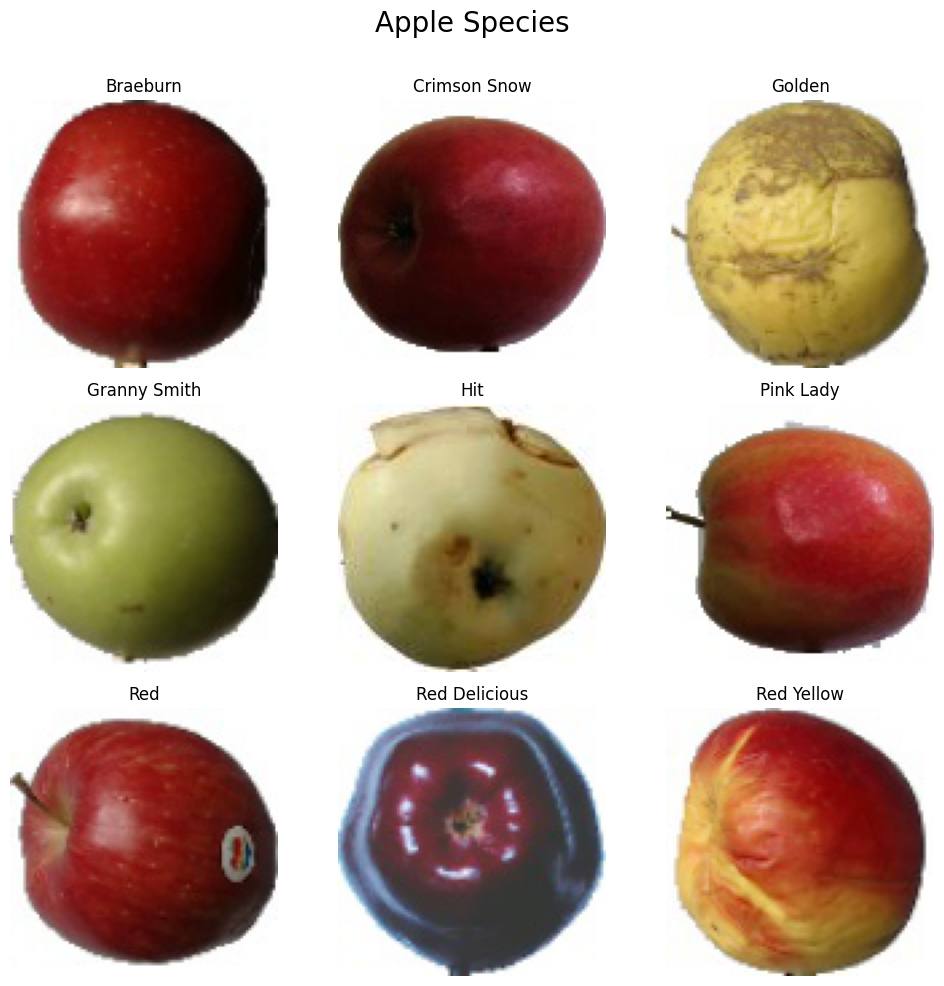

In [9]:
# Display one image from each apple species in a 3x3 grid

def normalize_name(name: str) -> str:
    # lowercase → split by space → drop trailing number if it's a digit
    name = name.lower().strip()
    parts = name.split()
    if parts and parts[-1].isdigit():
        parts = parts[:-1]
    return ' '.join(parts)

def get_imgs(apple_dataset: Path, apple_species: list[str]):
    seen_species = set()
    info = []
    normalized_species_set = {normalize_name(name) for name in apple_species}
    
    for dir in sorted(apple_dataset.iterdir()):
        if dir.is_dir():
            species_name = normalize_name(dir.name)
            if species_name in normalized_species_set and species_name not in seen_species:
                for img in dir.iterdir():
                    if img.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        info.append((species_name, img))
                        seen_species.add(species_name)
                        break

    return sorted(info, key=lambda x: apple_species.index(x[0]))

def display_apple_species(apple_dataset: Path, apple_species: list[str]):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # ← smaller figure
    fig.suptitle('Apple Species\n', fontsize=20)
    axes = axes.flatten()
    img_paths = get_imgs(apple_dataset, apple_species)

    for ax, (name, img_path) in zip(axes, img_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(name.replace('apple ', '').title(), fontsize=12)  # smaller font
        ax.axis('off')

    for ax in axes[len(img_paths):]:
        ax.axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()


# Display the apple species
display_apple_species(apple_trainning, apple_species=apple_species)


## **Models**  

For this project, a `convolutional neural network (CNN)` will be used alongside several transfer learning models to optimize the classification of different apple species. The transfer learning models include `MobileNetV2`, `ResNet50`, and `EfficientNetB0`. These models will be combined in an `ensemble` to enhance the model's ability to detect subtle visual differences between similar-looking apple varieties, such as Red Delicious and Braeburn.

### **Convolutional Neural Network**

In [8]:
# ---------------------------------- CONFIG ---------------------------------- #

BATCH_SIZE = 64
EPOCHS = 50
TARGET_SIZE = (100, 100, 3)  

# ------------------------------- DATA LOADING ------------------------------- #

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    apple_trainning,
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    apple_testing,
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

# --------------------------------- MODEL ---------------------------------- #

cnn = Sequential([
            Input(shape=TARGET_SIZE),
            Conv2D(128, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Conv2D(64, kernel_size=3, activation='relu'),
            Conv2D(32, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Dropout(0.5),
            Flatten(),
            Dense(5000, activation='relu'),
            Dense(1000, activation='relu'),
            Dense(train_generator.num_classes, activation='softmax')
        ])

# ---------------------------------- COMPILE --------------------------------- #

cnn.compile(
    optimizer='SGD', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

# --------------------------------- CALLBACKS -------------------------------- #

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# ----------------------------------- TRAIN ---------------------------------- #

history = cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# ------------------------------ SAVE THE MODEL ------------------------------ #

cnn.save("cnn_apple_classifier.keras")

with open('cnn_training.json', 'w') as f:
    json.dump(history.history, f, indent=4)

## **Ensamble**

#### **Initilization for Ensamble**

In [73]:
# ---------------------------------- CONFIG ---------------------------------- #

BATCH_SIZE = 64
EPOCHS = 50
MOBILENET_TARGET_SIZE = (100, 100, 3)
RESNET_EFFICINET_TARGET_SIZE = (224, 224, 3)
FINE_TUNE_EPOCHS = 10

# ------------------------- MOBILENET DATA GENERATOR ------------------------- #

mobilenet_train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

mobilenet_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# -------------------------- MOBILENET DATA LOADING -------------------------- #

mobilenet_train_generator = mobilenet_train_datagen.flow_from_directory(
    apple_trainning,
    target_size=MOBILENET_TARGET_SIZE[:2],
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

mobilenet_test_generator = mobilenet_test_datagen.flow_from_directory(
    apple_testing,
    target_size=MOBILENET_TARGET_SIZE[:2],
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

# ------------------ RESNET AND EFFICIENTNET DATA GENERATOR ------------------ #

resnet_efficient_train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

resnet_efficient_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# ------------------- RESNET AND EFFICIENTNET DATA LOADING ------------------- #

resnet_efficient_train_generator = resnet_efficient_train_datagen.flow_from_directory(
    apple_trainning,
    target_size=RESNET_EFFICINET_TARGET_SIZE[:2],
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

resnet_efficient_test_generator = resnet_efficient_test_datagen.flow_from_directory(
    apple_testing,
    target_size=RESNET_EFFICINET_TARGET_SIZE[:2],
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# ----------------------------------- STEPS ---------------------------------- #

steps_per_epoch = int(np.ceil(mobilenet_train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(mobilenet_test_generator.samples / BATCH_SIZE))

# -------------------------------- CALL BACKS -------------------------------- #

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# ------------------------------- SAVE FUNCTION ------------------------------ #

def combine_history(history, history_fine):
    # Combine and save history (basic version)
    full_history = history.history
    for k, v in history_fine.history.items():
        full_history[k] += v  # Append fine-tuned values
    return full_history

def save(model, model_path, history, history_fine, history_path):
    model.save(model_path)

    with open(history_path, 'w') as f:
        json.dump(combine_history(history, history_fine), f, indent=4)

Found 7106 images belonging to 14 classes.
Found 2368 images belonging to 14 classes.
Found 7106 images belonging to 14 classes.
Found 2368 images belonging to 14 classes.


#### **MobileNetV2**

In [74]:
# ---------------------------------------------------------------------------- #
#                                  MOBILE NET                                  #
# ---------------------------------------------------------------------------- #

base_mobilenet = MobileNetV2(
    input_shape=MOBILENET_TARGET_SIZE,
    include_top=False,
    weights='imagenet'
)
base_mobilenet.trainable = False  # Freeze initially

# Classification head with regularization
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(mobilenet_train_generator.num_classes, activation='softmax')(x)

mobileNet = Model(inputs=base_mobilenet.input, outputs=outputs)

# ---------------------------------- COMPILE --------------------------------- #

mobileNet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ----------------------------------- TRAIN ---------------------------------- #

history = mobileNet.fit(
    mobilenet_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=mobilenet_test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ------------------------------- FINE-TUNNING ------------------------------- #

# Unfreeze top layers of base model
base_mobilenet.trainable = True
for layer in base_mobilenet.layers[:-30]:
    layer.trainable = False

# Re-compile with lower learning rate
mobileNet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = mobileNet.fit(
    mobilenet_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=mobilenet_test_generator,
    validation_steps=validation_steps,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ----------------------------------- SAVE ----------------------------------- #

save(
    mobileNet, 
    'mobilenet_apple_classifier.keras', 
    history, 
    history_fine, 
    'mobilenet_training.json'
)

/var/folders/cr/yv07lwcs6q9f6v3scts_1x0r0000gn/T/ipykernel_23238/4037937483.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.4771 - loss: 2.0334 - val_accuracy: 0.8501 - val_loss: 1.0018 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.7870 - loss: 1.1466 - val_accuracy: 0.8898 - val_loss: 0.8904 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.8326 - loss: 1.0384 - val_accuracy: 0.8758 - val_loss: 0.8919 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.8497 - loss: 0.9853 - val_accuracy: 0.8898 - val_loss: 0.8644 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.8708 - loss: 0.9530 - val_accuracy: 0.8885 - val_loss: 0.8488 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.8658 - loss: 0.9516 - val_accuracy: 0.8915 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.8

#### **ResNet50**

In [79]:
# ---------------------------------------------------------------------------- #
#                                   RESNET50                                   #
# ---------------------------------------------------------------------------- #
    
base_resnet = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_resnet.trainable = False  # Freeze initially

# Classification head with regularization
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

resNet = Model(inputs=base_resnet.input, outputs=outputs)

# ---------------------------------- COMPILE --------------------------------- #

resNet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ----------------------------------- TRAIN ---------------------------------- #

history = resNet.fit(
    resnet_efficient_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=resnet_efficient_test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ------------------------------- FINE-TUNNING ------------------------------- #

# Unfreeze top layers of base model
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

# Re-compile with lower learning rate
resNet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = resNet.fit(
    resnet_efficient_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=resnet_efficient_test_generator,
    validation_steps=validation_steps,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ----------------------------------- SAVE ----------------------------------- #

save(
    resNet, 
    'resnet_apple_classifier.keras', 
    history, 
    history_fine, 
    'resnet_training.json'
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1384 - loss: 3.1036

/Users/robbykapua/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.1388 - loss: 3.1012 - val_accuracy: 0.0693 - val_loss: 2.7526 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.2323 - loss: 2.4953 - val_accuracy: 0.1161 - val_loss: 2.5882 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.2632 - loss: 2.3444 - val_accuracy: 0.3332 - val_loss: 2.2892 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.2836 - loss: 2.2584 - val_accuracy: 0.2969 - val_loss: 2.2056 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.3106 - loss: 2.2024 - val_accuracy: 0.3129 - val_loss: 2.0876 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.3174 - loss: 2.1590 - val_accuracy: 0.3940 - val_loss: 1.9805 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.3235 - loss: 2.1327 - val_

#### **EfficientNetB0**

In [75]:
# ---------------------------------------------------------------------------- #
#                                EFFICIENTNETB0                                #
# ---------------------------------------------------------------------------- #

base_efficientnet = EfficientNetB0(
    input_shape=(100, 100, 3),  # Ensure this matches your image resizing
    include_top=False,
    weights='imagenet'
)

base_efficientnet.trainable = False  # Freeze initially

# Classification head with regularization
x = base_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(mobilenet_train_generator.num_classes, activation='softmax', dtype='float32')(x)  # force float32

efficientNet = Model(inputs=base_efficientnet.input, outputs=outputs)

# ---------------------------------- COMPILE --------------------------------- #

efficientNet.compile(
    optimizer=Adam(learning_rate=5e-4),  # Lower LR for smoother convergence
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ----------------------------------- TRAIN ---------------------------------- #

history = efficientNet.fit(
    mobilenet_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=mobilenet_test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ------------------------------- FINE-TUNNING ------------------------------- #

# Unfreeze top layers of base model
base_efficientnet.trainable = True
for layer in base_efficientnet.layers[:-30]:
    layer.trainable = False

# Re-compile with lower learning rate
efficientNet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = efficientNet.fit(
    mobilenet_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=mobilenet_test_generator,
    validation_steps=validation_steps,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ----------------------------------- SAVE ----------------------------------- #

save(
    efficientNet, 
    'efficientnet_apple_classifier.keras', 
    history, 
    history_fine, 
    'efficientnet_training.json'
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.0739 - loss: 3.4033 - val_accuracy: 0.0693 - val_loss: 2.6785 - learning_rate: 5.0000e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.0777 - loss: 3.0594 - val_accuracy: 0.0693 - val_loss: 2.7300 - learning_rate: 5.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.0749 - loss: 2.9447 - val_accuracy: 0.0693 - val_loss: 2.7232 - learning_rate: 5.0000e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.0780 - loss: 2.9149 - val_accuracy: 0.0676 - val_loss: 2.7213 - learning_rate: 1.5000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.0779 - loss: 2.8969 - val_accuracy: 0.0676 - val_loss: 2.7064 - learning_rate: 1.5000e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.0790 - loss: 2.8766 - val_accuracy: 0.0676 - val_loss: 2.6967 - learning_rate: 4.5000e-05
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 34s 23

### **Evaluation**

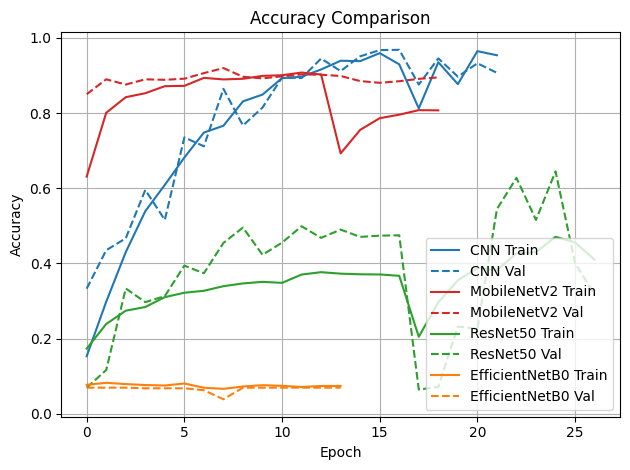

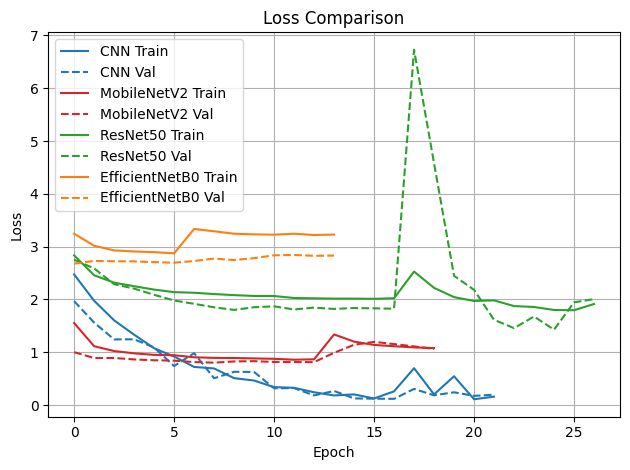

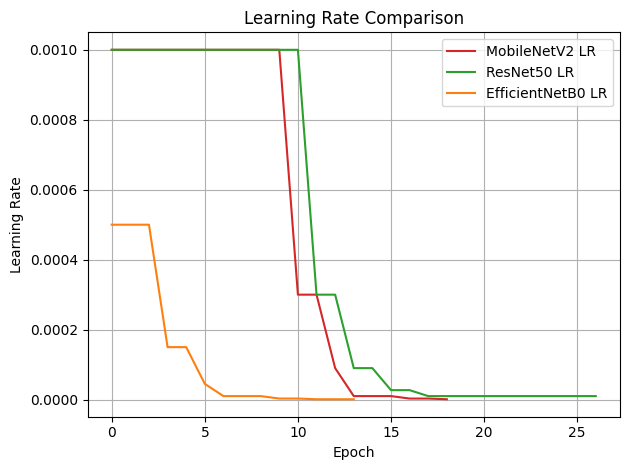

In [76]:
# ----------------------------- TRAINING HISTORY ----------------------------- #

CNN_HISTORY_PATH = Path("cnn_training.json")
MOBILENET_HISTORY_PATH = Path("mobilenet_training.json")
RESNET_HISTORY_PATH = Path("resnet50_training.json")
EFFICIENTNET_HISTORY_PATH = Path("efficientnet_training.json")

# ------------------------------ TYPE DEFINITIONS ---------------------------- #

class TrainingHistory(TypedDict):
    accuracy: list[float]
    loss: list[float]
    val_accuracy: list[float]
    val_loss: list[float]

CNNTrainingHistory = TrainingHistory

class MobileNetTrainingHistory(TrainingHistory):
    learning_rate: list[float]

ResNetTrainningHistory = MobileNetTrainingHistory

EfficientNetTrainingHistory = MobileNetTrainingHistory

# -------------------------------- LOAD HISTORY ------------------------------ #

with open(CNN_HISTORY_PATH, 'r') as f:
    cnn_history: CNNTrainingHistory = json.load(f)

with open(MOBILENET_HISTORY_PATH, 'r') as f:
    mobilenet_history: MobileNetTrainingHistory = json.load(f)

with open(RESNET_HISTORY_PATH, 'r') as f:
    resnet_history: ResNetTrainningHistory = json.load(f)

with open(EFFICIENTNET_HISTORY_PATH, 'r') as f:
    efficientnet_history: EfficientNetTrainingHistory = json.load(f)

# -------------------------- PLOT TRAINING FUNCTION -------------------------- #

def plot_comparison(histories: dict[str, dict[str, list[float]]], metrics: list[str] = ["accuracy", "loss"]):
    """
    Plots superimposed training and validation curves for multiple models.
    Each model gets its own color; solid line = train, dashed line = val.
    """
    model_colors = [
        "#1f77b4",  # blue
        "#d62728",  # red
        "#2ca02c",  # green
        "#ff7f0e",  # orange
    ]

    model_names = list(histories.keys())
    color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(model_names)}

    for metric in metrics:
        plt.figure()

        for name in model_names:
            history = histories[name]
            color = color_map[name]

            if metric in history:
                plt.plot(history[metric], label=f"{name} Train", color=color, linestyle='-')
            if f"val_{metric}" in history:
                plt.plot(history[f"val_{metric}"], label=f"{name} Val", color=color, linestyle='--')

        plt.title(f"{metric.capitalize()} Comparison")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Optional: learning rate plot
    if any("learning_rate" in h for h in histories.values()):
        plt.figure()
        for name in model_names:
            history = histories[name]
            if "learning_rate" in history:
                plt.plot(history["learning_rate"], label=f"{name} LR", color=color_map[name])
        plt.title("Learning Rate Comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_comparison({
    "CNN": cnn_history,
    "MobileNetV2": mobilenet_history,
    "ResNet50": resnet_history,
    "EfficientNetB0": efficientnet_history
})

Based on the training results, we can see that the CNN and MobileNet models achieved the highest accuracy, while the ResNet and EfficientNet models performed noticeably worse. This performance gap may be due to several factors.

Although the CNN achieved strong accuracy, there is a concern that it may have overfit the training data, which could lead to poor generalization during prediction. In contrast, while MobileNet was slightly less accurate during training, the use of fine-tuning may help mitigate overfitting and improve its performance on unseen data.

The ResNet and EfficientNet models likely underperformed because they are pre-trained on datasets with higher-resolution images (typically 224×224), whereas this dataset consists of 100×100 images. Although I attempted to address this by resizing the images during training, the small dataset size may have limited the models' ability to effectively leverage their complex architectures.

The training and validation loss trends for all four models—CNN, MobileNet, ResNet, and EfficientNet—also support these observations, clearly highlighting the relative accuracy and generalization capability of each model.

## **Application**

In [2]:
# --------------------------------- GET MODEL -------------------------------- #

model_types = {
    "cnn": "cnn_apple_classifier.keras",
    "mobilenet" : "mobilenetv2_apple_classifier.keras",
    "resnet": "resnet50_apple_classifier.keras",
    "efficientnet": "efficientnet_apple_classifier.keras"
    }

print("Available models:")
for i, model in enumerate(model_types.keys()):
    print(f"  - ({i+1}) {model}")
print(f"  - ({len(model_types) + 1}) ensemble")
choice = input("Select a model (1-5): ")

try:
    if choice == str(len(model_types) + 1):
        model_path = None
        print("Selected model: ensemble")
    else:
        model_choice = list(model_types.keys())[int(choice) - 1]
        model_path = model_types[model_choice]
        model_path = Path(model_path)
        print(f"Selected model: {model_choice}")
except (IndexError):
    raise IndexError(f"Invalid choice: {choice}. Please select a valid model number.")

# -------------------------------- LOAD MODEL -------------------------------- #

model = load_model(model_path) if model_path else None

Available models:
  - (1) cnn
  - (2) mobilenet
  - (3) resnet
  - (4) efficientnet
  - (5) ensemble
Selected model: mobilenet


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


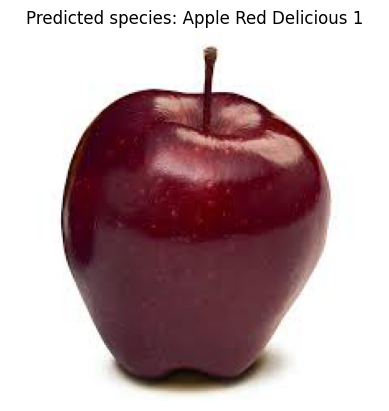

Top 5 predictions:
1. Apple Red Delicious 1 (0.35)
2. Apple Braeburn 1 (0.16)
3. Apple Pink Lady 1 (0.12)
4. Apple Red Yellow 2 (0.12)
5. Apple Red 2 (0.04)


In [8]:
# ------------------------------- APPLE SPECIES ------------------------------ #

species = os.listdir(apple_testing)
species.sort()
num_species = len(species)

# --------------------------------- GET IMAGE -------------------------------- #

img_folder = Path('images')

# UPLOAD YOUR IMAGE HERE
img_path = img_folder / 'rd_1.jpeg'

# ------------------------------- PROCESS IMAGE ------------------------------ #

img = load_img(img_path, target_size=(100, 100))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the image

# ------------------------------- PREDICT IMAGE ------------------------------ #

if model:
    predictions = model.predict(img, verbose=1)
    predicted_species = species[np.argmax(predictions[0])]
else:
    # Ensemble prediction
    predictions = []
    for model_path in list(model_types.values())[:1]:
        model = load_model(model_path)
        pred = model.predict(img, verbose=1)
        predictions.append(pred)
    predictions = np.mean(predictions, axis=0)
    predicted_species = species[np.argmax(predictions[0])]

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"Predicted species: {predicted_species}")
plt.axis('off')
plt.show()

# ----------------------------- TOP 5 PREDICTIONS ---------------------------- #

top_5_indices = np.argsort(predictions[0])[-5:][::-1]
top_5_species = [species[i] for i in top_5_indices]
top_5_probabilities = [predictions[0][i] for i in top_5_indices]
print("Top 5 predictions:")
for i, (species, prob) in enumerate(zip(top_5_species, top_5_probabilities)):
    print(f"{i + 1}. {species} ({prob:.2f})")


## **Results**

The results from using the different models support the idea that the CNN likely overfit the training data. This became evident when the model struggled to distinguish between visually similar apple species—such as Red Delicious and Braeburn, or Granny Smith and Golden apples—despite its high training accuracy. This lack of generalization could be due to the limited diversity within the dataset and the simplicity of the CNN model, which may have memorized features rather than learned robust patterns. While additional fine-tuning may have helped reduce overfitting, the model still lacked the flexibility needed for subtle visual distinctions.

In contrast, MobileNetV2 performed notably well in identifying several apple species, including Granny Smith, Red Delicious, Braeburn, and Pink Lady. Although it occasionally struggled with different shades of red apples—where fine-grained differences are minimal—it consistently outperformed the other transfer learning models. ResNet50 and EfficientNetB0, while occasionally making correct predictions, were generally unreliable on their own. I had originally hoped that ensembling these transfer models would result in a more robust and accurate "super model." However, due to the consistently low performance of ResNet and EfficientNet, the ensemble did not yield significant improvements. MobileNetV2 alone remained the strongest performer.

Although I am pleased with MobileNet’s accuracy and generalization, I had hoped that ResNet and EfficientNet would have contributed more to the ensemble. I experimented with various training parameters—such as batch size, learning rate, and the number of trainable layers—but was unable to significantly improve their performance. It’s possible that the limited dataset size, the resolution mismatch, or the complexity of these architectures prevented them from reaching their full potential. In the future, training on a larger dataset or leveraging additional data augmentation strategies may help improve the performance of deeper models like ResNet and EfficientNet.

## **Conclusion**

This project explored the classification of apple species using both a custom CNN and several transfer learning models, including MobileNetV2, ResNet50, and EfficientNetB0. The Fruits360 dataset was filtered to isolate apple images, and multiple preprocessing and augmentation strategies were used to enhance model generalization.

Among all models, MobileNetV2 achieved the best balance of accuracy and generalization. It demonstrated strong performance on various apple species—such as Granny Smith, Red Delicious, Braeburn, and Pink Lady—despite occasionally struggling to distinguish subtle visual differences between similar red apple varieties. Fine-tuning MobileNetV2 helped reduce overfitting and improve prediction robustness.

While the custom CNN showed high training accuracy, it appeared to overfit the dataset, likely due to its simplicity and the relatively low diversity in the training set. This was evident in its difficulty distinguishing apples with similar colors and shapes. ResNet50 and EfficientNetB0 underperformed overall, which may be attributed to the resolution mismatch (224×224 expected vs. 100×100 actual) and the complexity of these architectures relative to the size and variability of the dataset.

An ensemble approach was attempted to combine the strengths of each model, but due to the poor individual performance of ResNet and EfficientNet, the ensemble did not improve significantly over MobileNet alone.

In future iterations, increasing dataset diversity, using higher-resolution apple images, and applying more aggressive data augmentation could help improve the performance of deeper models. Nevertheless, this project successfully demonstrated that lightweight models like MobileNetV2 are highly effective for fine-grained image classification tasks when trained and tuned appropriately.
